#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현 프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [16]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공 신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함수 관련 모듈
import torch.optim as optim     # 최적화 기법 관련 모듈

import pandas as pd             # 데이터 파일 분석 관련 모듈
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [17]:
torch.manual_seed(2)

In [18]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE = '../../ML/data/iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습 방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [19]:
# in_features : sepal.length, sepal.width, petal.length     3개
# out_features : petal.width        1개
model = nn.Linear(3,1)  # 선형 모델
nn_model = nn.Sequential(nn.Linear(3,10),
                         nn.ReLU(),
                         nn.Linear(10,50),
                         nn.ReLU(),
                         nn.Linear(50,1))

In [20]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[ 0.1324, -0.1374,  0.1583]], requires_grad=True)

[bias] Parameter containing:
tensor([-0.0295], requires_grad=True)



[3] 최적화 인스턴스 준비

In [21]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim = optim.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행하거나 학습 전 진행

In [22]:
featureTS = torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([150, 3])

In [23]:
targetTS = torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape

torch.Size([150, 1])

In [24]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS, test_size=0.2)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(f'[Feature] TRAIN {X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[Target]  TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')

[Feature] TRAIN torch.Size([96, 3]), TEST torch.Size([30, 3]), VAL torch.Size([24, 3])
[Target]  TRAIN torch.Size([96, 1]), TEST torch.Size([30, 1]), VAL torch.Size([24, 1])


- [4-2] 학습 진행
    * 학습 횟수 결정 ==> 에포크 설정
    * 학습 결과 저장 ==> 손실 저장 변수

In [25]:
EPOCH = 10
loss_history = []

In [26]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
def testing(testTS, targetTS, kind='Val'):

    with torch.no_grad():   # 가중치, 절편 업데이트 X
        # (1) 학습 진행 - forward
        pre_y = model(testTS)
        print(f'{pre_y.shape}')
        
        # (2) 오차 계산 - 손실 함수
        loss = F.mse_loss(pre_y, targetTS)

        # (3) 학습 결과 출력 및 저장
        print(f'[{kind}] Loss : {loss}')
    return loss

In [27]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    loss_history = [[],[]]
    
    for epoch in range(EPOCH):
        # (1) 학습 진행 - forward
        pre_y = model(featureTS)

        # (2) 오차 계산 - 손실 함수
        loss = F.mse_loss(pre_y, targetTS)
        loss_history[0].append(loss.item())

        # (3) 최적화 -  가중치, 절편, 업데이트 backward
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # (4) 검증 - 모델이 제대로 만들어 지는지 검사
        val_loss = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())

        # (5) 학습 결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] Loss : {loss}')
    
    return loss_history

In [28]:
# 모델 학습 진행
loss = training(X_train, y_train, X_val, y_val)

torch.Size([24, 1])
[Val] Loss : 1.161185383796692
[0/10] Loss : 0.20691843330860138
torch.Size([24, 1])
[Val] Loss : 0.2158052921295166
[1/10] Loss : 1.3075580596923828
torch.Size([24, 1])
[Val] Loss : 0.32541507482528687
[2/10] Loss : 0.227860689163208
torch.Size([24, 1])
[Val] Loss : 0.6901593804359436
[3/10] Loss : 0.32013463973999023
torch.Size([24, 1])
[Val] Loss : 0.4682546854019165
[4/10] Loss : 0.7122273445129395
torch.Size([24, 1])
[Val] Loss : 0.1394505798816681
[5/10] Loss : 0.4697856903076172
torch.Size([24, 1])
[Val] Loss : 0.11959127336740494
[6/10] Loss : 0.12319210171699524
torch.Size([24, 1])
[Val] Loss : 0.2922538220882416
[7/10] Loss : 0.12826505303382874
torch.Size([24, 1])
[Val] Loss : 0.3200817406177521
[8/10] Loss : 0.34307363629341125
torch.Size([24, 1])
[Val] Loss : 0.17509858310222626
[9/10] Loss : 0.3812091052532196


In [29]:
loss

[[0.20691843330860138,
  1.3075580596923828,
  0.227860689163208,
  0.32013463973999023,
  0.7122273445129395,
  0.4697856903076172,
  0.12319210171699524,
  0.12826505303382874,
  0.34307363629341125,
  0.3812091052532196],
 [1.161185383796692,
  0.2158052921295166,
  0.32541507482528687,
  0.6901593804359436,
  0.4682546854019165,
  0.1394505798816681,
  0.11959127336740494,
  0.2922538220882416,
  0.3200817406177521,
  0.17509858310222626]]

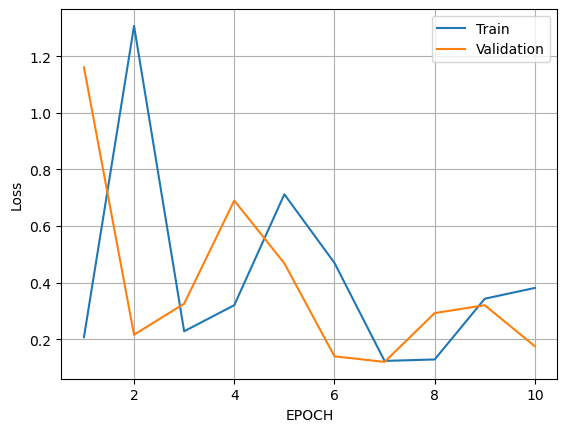

In [30]:
# 학습 후 loss 시각화
plt.plot(range(1,11),loss[0], label='Train')
plt.plot(range(1,11), loss[1], label='Validation')
plt.grid('--')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.show()